Прообраз: https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [7]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)


# Фильтрация

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)

# Убираются слова, которые попадаются всего в n процентов документов
dictionary.filter(min_df_rate=0.01)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)

75725
75180
19310
1819


In [8]:
# Установка количества тем
topic_count = 10

# Создание модели
model_artm = artm.ARTM(
    topic_names=['topic_{}'.format(i) for i in range(topic_count)],
    scores=[
        artm.PerplexityScore(
            name='PerplexityScore',
            dictionary=dictionary
        )
    ],
    #regularizers=[
    #    artm.SmoothSparseThetaRegularizer(
    #        name='SparseTheta', 
    #        tau=-0.15
    #    )
    #],
    cache_theta=True,
    #class_ids={'text': 1.0},
)

# Инициализация модели
model_artm.initialize(dictionary=dictionary)

In [9]:
# Установка отслеживаемых параметров
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
#model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -0.2
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [10]:
model_artm.num_document_passes = 1

In [20]:
# Первичное обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=500)

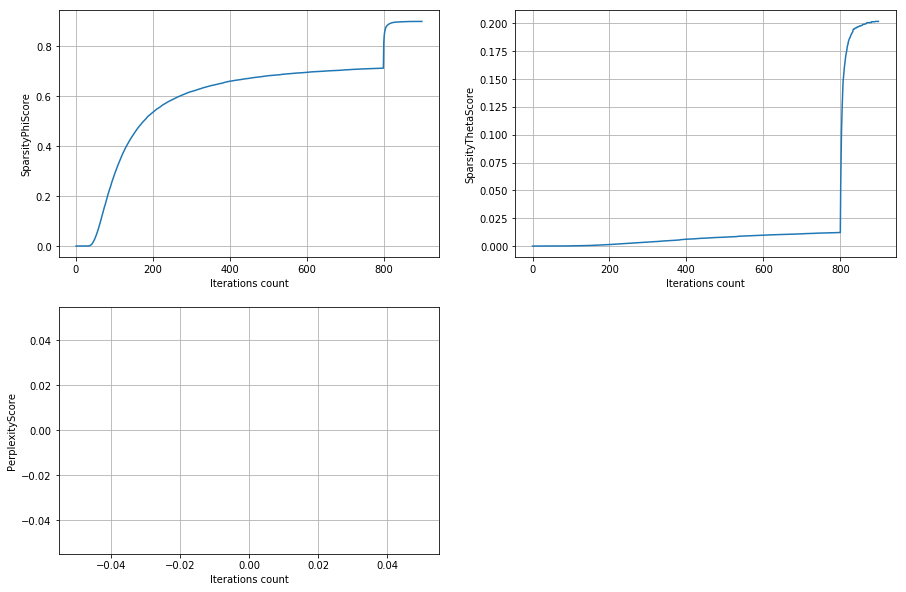

In [33]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(221)   #top left
ax1.plot(model_artm.score_tracker["SparsityPhiScore"].value)
ax1.set_xlabel('Iterations count')
ax1.set_ylabel('SparsityPhiScore')
ax1.grid(True)

ax2 = fig.add_subplot(222)   #top right
ax2.plot(model_artm.score_tracker["SparsityThetaScore"].value)
ax2.set_xlabel('Iterations count')
ax2.set_ylabel('SparsityThetaScore')
ax2.grid(True)

ax3 = fig.add_subplot(223)   #bottom left
ax3.plot(model_artm.score_tracker["PerplexityScore"].value)
ax3.set_xlabel('Iterations count')
ax3.set_ylabel('PerplexityScore')
ax3.grid(True)

plt.show()

In [22]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ',)
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['использовать', 'разный', 'любой', 'мало', 'тюрьма', 'почти']
topic_1: 
['партия', 'призыв', 'публичный', 'открытый', 'вконтакте', 'выборы']
topic_2: 
['отменять', 'освобождать', 'сообщество', 'юрий', 'изолятор', 'компенсация']
topic_3: 
['особо', 'предприятие', 'бизнесмен', 'мошенничество', 'должность', 'министр']
topic_4: 
['сидеть', 'бить', 'увидеть', 'вернуться', 'пойти', 'сначала']
topic_5: 
['ударять', 'превышение', 'подросток', 'умирать', 'повреждение', 'тяжкий']
topic_6: 
['помнить', 'видеозапись', 'задавать', 'напоминать', 'обращать', 'читать']
topic_7: 
['теракт', 'взрыв', 'покушение', 'хранение', 'вооруженный', 'подготовка']
topic_8: 
['иностранный', 'госдума', 'список', 'комиссия', 'еспча', 'нарушать']
topic_9: 
['пистолет', 'попытаться', 'скрываться', 'нападать', 'происшествие', 'ранение']


In [23]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7122045159339905
0.012163424864411354


In [24]:
print(model_artm.get_phi())

                      topic_0   topic_1       topic_2       topic_3   topic_4  \
семейный         0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000250   
жительница       0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000   
взыскание        0.000000e+00  0.000000  3.442479e-03  1.466101e-05  0.000000   
сокращать        0.000000e+00  0.000000  4.912064e-04  3.204644e-03  0.000000   
вменять          0.000000e+00  0.001133  3.869751e-03  0.000000e+00  0.000000   
объединение      0.000000e+00  0.004412  0.000000e+00  0.000000e+00  0.000000   
памятник         0.000000e+00  0.003861  0.000000e+00  0.000000e+00  0.000000   
дежурный         0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000728   
готовый          3.876105e-03  0.000000  0.000000e+00  8.700170e-04  0.000000   
столкновение     0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000   
религиозный      0.000000e+00  0.007333  0.000000e+00  0.000000e+00  0.000000   
определять       1.797561e-0

In [25]:
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-5*1e5, dictionary=dictionary),
    overwrite=True,
)

In [30]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

In [31]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ',)
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['использовать', 'нужно', 'создавать', 'третий', 'почти', 'отсутствие']
topic_1: 
['партия', 'призыв', 'социальный', 'публичный', 'телеканал', 'политика']
topic_2: 
['николай', 'юрий', 'сообщество', 'потребовать', 'изолятор', 'прекращать']
topic_3: 
['особо', 'предприятие', 'бизнесмен', 'мошенничество', 'занимать', 'должность']
topic_4: 
['сидеть', 'отец', 'вспоминать', 'дверь', 'бить', 'правый']
topic_5: 
['служебный', 'ударять', 'превышение', 'повреждение', 'подросток', 'умирать']
topic_6: 
['помнить', 'поддерживать', 'минута', 'коллега', 'событие', 'снова']
topic_7: 
['покушение', 'известный', 'официальный', 'подозревать', 'офис', 'борис']
topic_8: 
['возможность', 'иностранный', 'госдума', 'подписывать', 'министерство', 'список']
topic_9: 
['удаваться', 'пистолет', 'угрожать', 'накануне', 'открывать', 'проводиться']


In [32]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8992853164672852
0.20184320211410522


Полезные идеи по нулевым значениям:
https://github.com/bigartm/bigartm/issues/664

In [38]:
model_artm.score_tracker

{'PerplexityScore': <artm.score_tracker.PerplexityScoreTracker at 0x104a838d0>,
 'SparsityPhiScore': <artm.score_tracker.SparsityPhiScoreTracker at 0x10ed47c88>,
 'SparsityThetaScore': <artm.score_tracker.SparsityThetaScoreTracker at 0x10ed47cf8>,
 'TopTokensScore': <artm.score_tracker.TopTokensScoreTracker at 0x1119dcbe0>,
 'TopicKernelScore': <artm.score_tracker.TopicKernelScoreTracker at 0x10ed47d30>}